In [1]:
import numpy as np
from matplotlib import pyplot as plt
import sys
sys.path.append('../')
import multi_axis as ma
%config Completer.use_jedi = False

In [2]:
def omf_to_mag(data):
    """ Extract magnetization in grid array from ubermag 'system' object """
    #ms = system.m.array
    ms = data
    shape = np.shape(ms)

    xs,ys,zs,mx,my,mz = [],[],[],[],[],[]
    for i in range(shape[0]):
        for j in range(shape[1]):
            for k in range(shape[2]):
                xs.append(i)
                ys.append(j)
                zs.append(k)
                mx.append(ms[i][j][k][0])
                my.append(ms[i][j][k][1])
                mz.append(ms[i][j][k][2])
    Mx,My,Mz = np.reshape(mx,(shape[0],shape[1],shape[2])),\
                            np.reshape(my,(shape[0],shape[1],shape[2])), \
                            np.reshape(mz,(shape[0],shape[1],shape[2]))
    return Mx,My,Mz

def plot_2d_mag_slice(mx,my,mz,mesh_params=None,Ms=None,s=1):
    """ Takes x/y magnetisation projections and creates a plot
        uses quivers for direction and colour for magnitude """
    if type(Ms) == type(None):
        Ms = np.max(np.max((mx**2+my**2)**.5))
    
    fig = plt.figure(figsize=(5, 5))
    ax = plt.gca()

    if type(mesh_params) == type(None):
        p1 = (0,0,0)
        sx,sy = np.shape(mx)
        p2 = (sx,sy,sx)
        n = p2
    else:
        p1,p2,n = mesh_params
        
    x = np.linspace(p1[0],p2[0],num=n[0])
    y = np.linspace(p1[1],p2[1],num=n[1])
    xs,ys = np.meshgrid(x,y)
    
    plt.quiver(xs[::s,::s],ys[::s,::s],mx[::s,::s].T,my[::s,::s].T,pivot='mid',scale=Ms*22,width=0.009,headaxislength=5,headwidth=4,minshaft=1.8)
    mag = (mx**2+my**2)**.5
    plt.imshow(mz.T,origin='lower',extent=[p1[0],p2[0],p1[1],p2[1]],vmin=-Ms,vmax=Ms,cmap='RdBu_r')
    cbar = plt.colorbar(fraction=0.046, pad=0.04)
    cbar.set_label('$M_z$ / A/m ', rotation=-270,fontsize=15)
    
    plt.xlabel('x / m',fontsize=15)
    plt.ylabel('y / m',fontsize=15)
    plt.show()

In [3]:
# load magnetisation array
m = np.load(r'D-90nm_t-20nm_B-0T-skyrmion.npy')

# convert format
MX,MY,MZ = omf_to_mag(m)

# Pad z axis
MX = np.pad(MX,[(0,0),(0,0),(14,14)],mode='constant')
MY = np.pad(MY,[(0,0),(0,0),(14,14)],mode='constant')
MZ = np.pad(MZ,[(0,0),(0,0),(14,14)],mode='constant')

# cell size
#thickness = 20e-9
cell = (2.5e-9, 2.5e-9, 2.5e-9)
d = 90e-9
p1 = (0, 0, 0)
p2 = (d, d, d)#thickness)
n = (np.array(p2)/np.array(cell)).astype(int)
mesh_params = [p1,p2,n]

In [17]:
mesh_params

[(0, 0, 0), (9e-08, 9e-08, 9e-08), array([36, 36, 36])]

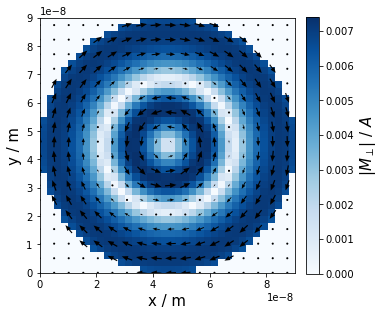

In [4]:
mx,my = ma.project_along_z(MX,mesh_params=mesh_params),ma.project_along_z(MY,mesh_params=mesh_params)
ma.plot_2d_mag(mx,my,mesh_params=mesh_params,s=2)

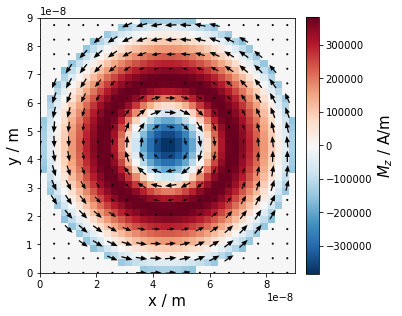

In [16]:
i=18
plot_2d_mag_slice(MX[::-1,::-1,i],MY[::-1,::-1,i],MZ[::-1,::-1,i],mesh_params=mesh_params,s=2)

In [6]:
ma.save_B_to_paraview('M_skyrmion.vts',MX,MY,MZ)

In [4]:
n=36
AX,AY,AZ,mesh_params2 = ma.calculate_A_3D(MX,MY,MZ,mesh_params=mesh_params,n_pad=n)
# B 3d
BX,BY,BZ = ma.calculate_B_from_A(AX,AY,AZ,mesh_params=mesh_params2)

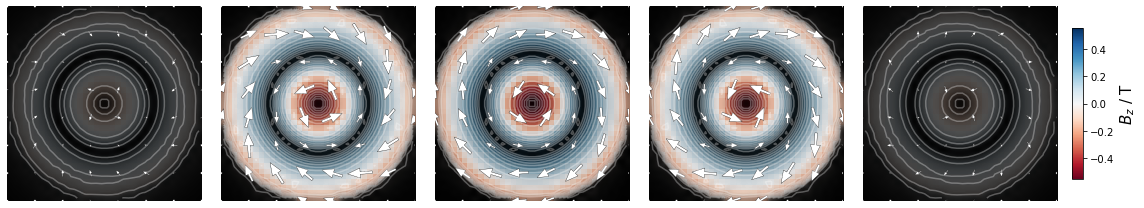

In [30]:
ma.plot_B_series(BX[n:-n,n:-n,n:-n],BY[n:-n,n:-n,n:-n],BZ[n:-n,n:-n,n:-n],slices=[13,15,19,20,22])

In [26]:
ma.save_B_to_paraview('B-true_skyrmion.vts',BX[n:-n,n:-n,n:-n],BY[n:-n,n:-n,n:-n],BZ[n:-n,n:-n,n:-n])

In [31]:
ma.save_B_to_paraview('A_skyrmion.vts',AX[n:-n,n:-n,n:-n],AY[n:-n,n:-n,n:-n],AZ[n:-n,n:-n,n:-n])

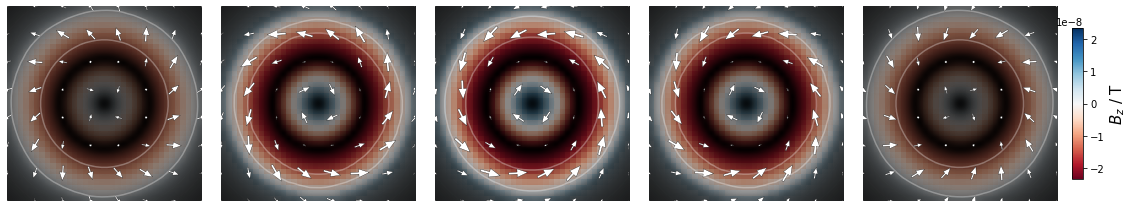

In [32]:
ma.plot_B_series(AX[n:-n,n:-n,n:-n],AY[n:-n,n:-n,n:-n],AZ[n:-n,n:-n,n:-n],slices=[13,15,19,20,22])

In [5]:
as_x,as_y,pxs,pys = ma.dual_axis_phase_generation(MX,MY,MZ,mesh_params,n_tilt= 71,a_range=70,n_pad=n)

Text(0.5, 1.0, '(70$^{\\circ}$, 0$^{\\circ}$, 0$^{\\circ}$)')

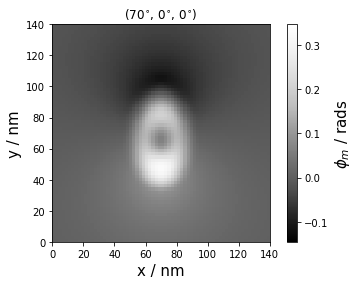

In [39]:
plt.imshow(np.flipud(pxs[20:-20,65,20:-20].T),cmap='Greys_r',vmax=np.max(pxs),vmin=np.min(pxs),extent=[0,140,0,140])
cbar = plt.colorbar()
cbar.set_label('$\phi_m$ / rads',fontsize=15)
plt.xlabel('x / nm',fontsize=15)
plt.ylabel('y / nm',fontsize=15)
plt.title('(%i$^{\circ}$, %i$^{\circ}$, %i$^{\circ}$)' % (as_x[70][0],as_x[70][1],as_x[70][2]))

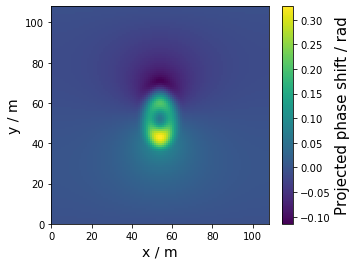

In [43]:
ma.plot_phase_proj(pxs[:,65,:])

In [91]:
import imageio

fpaths=[]
for i in np.arange(np.shape(pxs)[1]):
    fpath = r'gif/%i.png' % i
    
    plt.imshow(np.flipud(pxs[20:-20,i,20:-20].T),cmap='Greys_r',vmax=np.max(pxs),vmin=np.min(pxs),extent=[0,140,0,140])
    cbar = plt.colorbar()
    cbar.set_label('$\phi_m$ / rads',fontsize=15)
    plt.xlabel('x / nm',fontsize=15)
    plt.ylabel('y / nm',fontsize=15)
    plt.title('(%i$^{\circ}$, %i$^{\circ}$, %i$^{\circ}$)' % (as_x[i][0],as_x[i][1],as_x[i][2]))
    plt.savefig(fpath)
    fpaths.append(fpath)
    plt.close()
    
images = []
for f in fpaths:
    images.append(imageio.imread(f))
for f in fpaths[::-1]:
    images.append(imageio.imread(f))    
imageio.mimsave(r'gif/res.gif',images)

In [92]:
fpaths=[]
for i in np.arange(np.shape(pys)[1]):
    fpath = r'gif2/%i.png' % i
    
    plt.imshow(np.flipud(pys[20:-20,i,20:-20].T),cmap='Greys_r',vmax=np.max(pys),vmin=np.min(pys),extent=[0,140,0,140])
    cbar = plt.colorbar()
    cbar.set_label('$\phi_m$ / rads',fontsize=15)
    plt.xlabel('x / nm',fontsize=15)
    plt.ylabel('y / nm',fontsize=15)
    plt.title('(%i$^{\circ}$, %i$^{\circ}$, %i$^{\circ}$)' % (as_y[i][0],as_y[i][1],as_y[i][2]))
    plt.savefig(fpath)
    fpaths.append(fpath)
    plt.close()
    
images = []
for f in fpaths:
    images.append(imageio.imread(f))
for f in fpaths[::-1]:
    images.append(imageio.imread(f))    
imageio.mimsave(r'gif2/res.gif',images)

In [6]:
bxs,bys = ma.dual_axis_B_generation(pxs,pys,mesh_params2)

Text(0.5, 1.0, '(70$^{\\circ}$, 0$^{\\circ}$, 0$^{\\circ}$)')

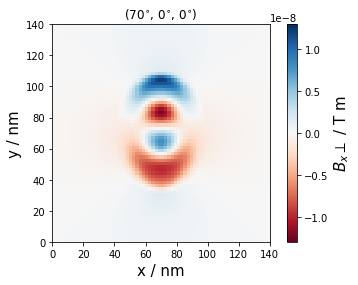

In [16]:
plt.imshow(np.flipud(bxs[20:-20,10,20:-20].T),cmap='RdBu',vmax=np.max(bxs),vmin=np.min(bxs),extent=[0,140,0,140])
cbar = plt.colorbar()
cbar.set_label(r'$B_x\perp$ / T m',fontsize=15)
plt.xlabel('x / nm',fontsize=15)
plt.ylabel('y / nm',fontsize=15)
plt.title('(%i$^{\circ}$, %i$^{\circ}$, %i$^{\circ}$)' % (as_x[70][0],as_x[70][1],as_x[70][2]))

In [24]:
from scipy import constants
def dual_axis_B_generation_2(pxs,pys,mesh_params):
    """ Returns bxs, bys (projected B fields for tilt series) 
    Calculates the BX/BY component from the y/x tilt series
    """
    # x tilt series --> derivative in x is good --> gives BY
    # x tilt series --> good for BX --> use the y derivative
    p1,p2,n = mesh_params
        
    x_size = p2[0]
    x_res = x_size/n[0]
    
    b_const = (constants.codata.value('mag. flux quantum')/(np.pi))
    bxs = []
    # calculate b component at each tilt
    for i in range(np.shape(pxs)[1]):
        p=pxs[:,i,:]
        # calculate_B_from_phase assumes input is ordered in the wierd way (i.e. flip.T)
        # but pxs/pys are somehow in the correct orientation, so we need to put them back for this to work
        # since gradient[0] gives the column gradient and [1] gives the row, so we'll get an incorrect answer
        p = np.flipud(p).T
        bx = - b_const*np.gradient(p,x_res)[0]
        #_,bx,_ = ma.calculate_B_from_phase(p,mesh_params=mesh_params)
        bxs.append(bx)
    
    bys = []
    # calculate b component at each tilt
    for i in range(np.shape(pys)[1]):
        p=pys[:,i,:]
        p = np.flipud(p).T
        by = b_const*np.gradient(p,x_res)[1]
        #_,_,by = calculate_B_from_phase(p,mesh_params=mesh_params)
        bys.append(by)
    
    # reorder for tomo
    bxs = np.transpose(bxs,axes=[1,0,2])
    bys = np.transpose(bys,axes=[1,0,2])
    
    return bxs,bys

In [30]:
bxs2,bys2 = dual_axis_B_generation_2(pxs,pys,mesh_params2)

Text(0.5, 1.0, '(70$^{\\circ}$, 0$^{\\circ}$, 0$^{\\circ}$)')

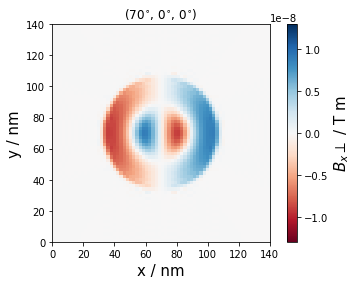

In [31]:
plt.imshow(np.flipud(bxs2[20:-20,35,20:-20].T),cmap='RdBu',vmax=np.max(bxs2),vmin=np.min(bxs2),extent=[0,140,0,140])
cbar = plt.colorbar()
cbar.set_label(r'$B_x\perp$ / T m',fontsize=15)
plt.xlabel('x / nm',fontsize=15)
plt.ylabel('y / nm',fontsize=15)
plt.title('(%i$^{\circ}$, %i$^{\circ}$, %i$^{\circ}$)' % (as_x[70][0],as_x[70][1],as_x[70][2]))

In [19]:
import imageio

fpaths=[]
for i in np.arange(np.shape(bxs)[1]):
    fpath = r'gif3/%i.png' % i
    
    plt.imshow(np.flipud(bxs2[20:-20,i,20:-20].T),cmap='RdBu',vmax=np.max(bxs2),vmin=np.min(bxs2),extent=[0,140,0,140])
    cbar = plt.colorbar()
    cbar.set_label(r'$B_x\perp$ / T m',fontsize=15)
    plt.xlabel('x / nm',fontsize=15)
    plt.ylabel('y / nm',fontsize=15)
    plt.title('(%i$^{\circ}$, %i$^{\circ}$, %i$^{\circ}$)' % (as_x[i][0],as_x[i][1],as_x[i][2]))
    plt.savefig(fpath)
    fpaths.append(fpath)
    plt.close()
    
images = []
for f in fpaths:
    images.append(imageio.imread(f))
for f in fpaths[::-1]:
    images.append(imageio.imread(f))    
imageio.mimsave(r'gif3/resbx-good.gif',images)

In [20]:
import imageio

fpaths=[]
for i in np.arange(np.shape(bys)[1]):
    fpath = r'gif4/%i.png' % i
    
    plt.imshow(np.flipud(bys2[20:-20,i,20:-20].T),cmap='RdBu',vmax=np.max(bys2),vmin=np.min(bys2),extent=[0,140,0,140])
    cbar = plt.colorbar()
    cbar.set_label(r'$B_x\perp$ / T m',fontsize=15)
    plt.xlabel('x / nm',fontsize=15)
    plt.ylabel('y / nm',fontsize=15)
    plt.title('(%i$^{\circ}$, %i$^{\circ}$, %i$^{\circ}$)' % (as_y[i][0],as_y[i][1],as_y[i][2]))
    plt.savefig(fpath)
    fpaths.append(fpath)
    plt.close()
    
images = []
for f in fpaths:
    images.append(imageio.imread(f))
for f in fpaths[::-1]:
    images.append(imageio.imread(f))    
imageio.mimsave(r'gif4/resby-good.gif',images)

In [28]:
n_iter=100
bx_recon,by_recon = ma.dual_axis_reconstruction(bxs2,bys2,as_x,as_y,mesh_params,niter=n_iter,algorithm='SIRT3D_CUDA',callback_freq=5)
bz_recon = ma.dual_axis_bz_from_bxby(bx_recon,by_recon)

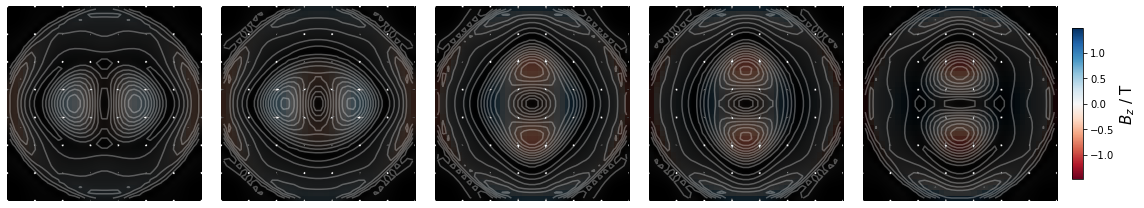

In [29]:
ma.plot_B_series(bx_recon[n:-n,n:-n,n:-n],by_recon[n:-n,n:-n,n:-n],bz_recon[n:-n,n:-n,n:-n],slices=[13,15,19,20,22])

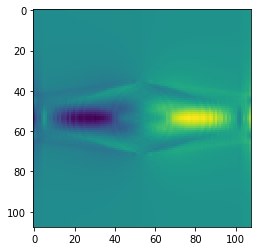

In [34]:
plt.imshow(by_recon[:,:,30])

In [23]:
ma.save_B_to_paraview('B-recon2_skyrmion.vts',bx_recon[n:-n,n:-n,n:-n],by_recon[n:-n,n:-n,n:-n],bz_recon[n:-n,n:-n,n:-n])

In [112]:
as_x,as_y,pxs,pys = ma.dual_axis_phase_generation(MX,MY,MZ,mesh_params,n_tilt= 91,a_range=90,n_pad=n)

In [114]:
bxs,bys = ma.dual_axis_B_generation(pxs,pys,mesh_params2)


In [115]:
bx_recon,by_recon = ma.dual_axis_reconstruction(bxs,bys,as_x,as_y,mesh_params,niter=n_iter,algorithm='SIRT3D_CUDA',callback_freq=5)
bz_recon = ma.dual_axis_bz_from_bxby(bx_recon,by_recon)

In [116]:
ma.save_B_to_paraview('B-recon2_skyrmion.vts',bx_recon[n:-n,n:-n,n:-n],by_recon[n:-n,n:-n,n:-n],bz_recon[n:-n,n:-n,n:-n])

/home/grl31/anaconda3/envs/astraenv/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


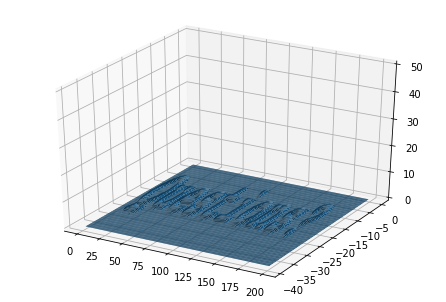

In [219]:
import numpy
import pylab
from PIL import Image, ImageDraw, ImageFont
import mpl_toolkits.mplot3d.axes3d as axes3d

img = Image.new('L', (200, 40), 255)
drw = ImageDraw.Draw(img)
#font = ImageFont.truetype("arial.ttf", 28, encoding="unic")
font = ImageFont.truetype("/usr/share/fonts/truetype/freefont/FreeMonoBold.ttf", size=30, encoding="unic")

drw.text((5, 1), 'Questions?',font=font)

X, Y = numpy.meshgrid(range(200), range(40))
Z = 1 - numpy.asarray(img) / 255

fig = pylab.figure()
ax = axes3d.Axes3D(fig)
ax.plot_surface(X, -Y, Z, rstride = 1, cstride = 1)
ax.set_zlim((0, 50))

fig.show()

In [220]:
d = img.getdata(0)
np.shape(img)

(40, 200)

In [221]:
data = np.array(d)
data = np.reshape(data, np.shape(img))
#data = data[:15,:]

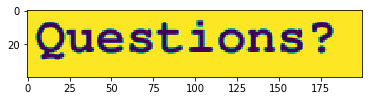

In [222]:
plt.imshow(data)

In [223]:
mx = np.array([data,data,data,data,data]).T*1e5
mx = np.pad(mx,((30,30),(30,30),(30,30)),mode='constant')
my = np.zeros_like(mx)
s = np.shape(mx)

In [224]:
mp = ([0,0,0],s,s)

In [225]:
p = ma.calculate_phase_M_2D(mx[:,::-1,:],my,my,mp)
_,bx,by = ma.calculate_B_from_phase(p,mesh_params=mp)

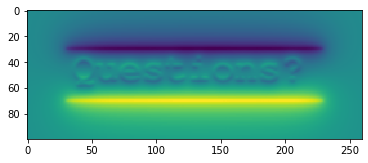

In [226]:
plt.imshow(p[:,::-1].T)
#plt.imshow(np.cos(p[:,::-1].T))

(0.0, 260.0, 0.0, 100.0)

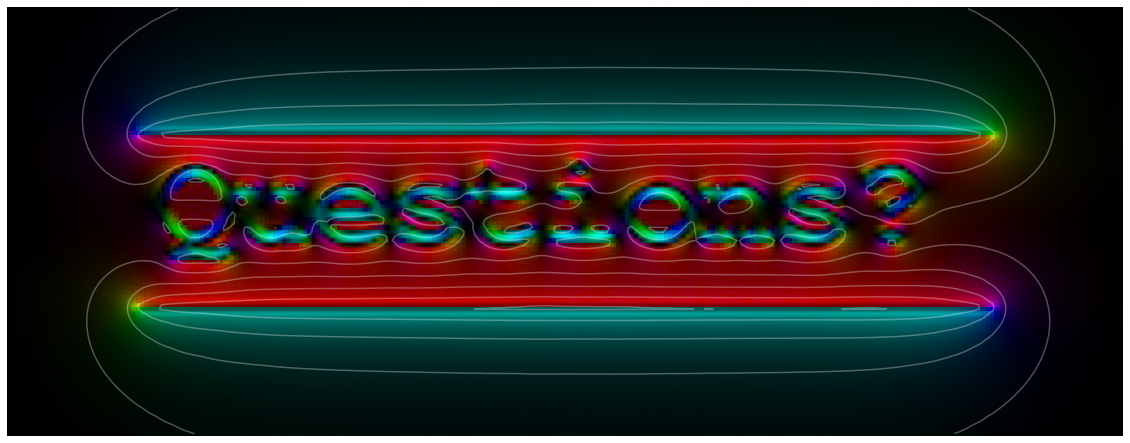

In [237]:
f,ax=plt.subplots(figsize=(20,20))
ma.plot_2d_B(bx,by,mesh_params=mp,quiver=False,phase=p,B_contour=False,ax=ax)
#ma.plot_2d_B(bx,by,mesh_params=mp,quiver=False,ax=ax)

plt.axis('off')

<class 'matplotlib.axes._subplots.AxesSubplot'>


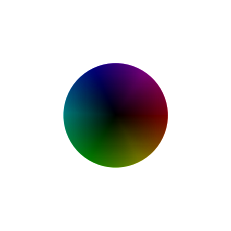

In [238]:
ma.plot_colorwheel()

/home/grl31/anaconda3/envs/astraenv/lib/python3.6/site-packages/matplotlib/quiver.py:696: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
/home/grl31/anaconda3/envs/astraenv/lib/python3.6/site-packages/matplotlib/quiver.py:696: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))
/home/grl31/anaconda3/envs/astraenv/lib/python3.6/site-packages/matplotlib/quiver.py:748: RuntimeWarning: invalid value encountered in less
  short = np.repeat(length < minsh, 8, axis=1)
/home/grl31/anaconda3/envs/astraenv/lib/python3.6/site-packages/matplotlib/quiver.py:762: RuntimeWarning: invalid value encountered in less
  tooshort = length < self.minlength


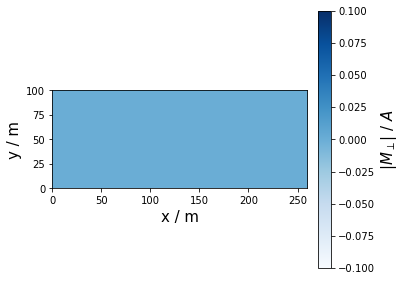

In [216]:
ma.plot_2d_mag(mx[:,::-1,0],my[:,:,0],mesh_params=mp)